## Project 1 Baseband Communications
### ECE 5625
By Caleb Moore, Kevyn Kelso

### I.A.1 System Calibration - No Noise

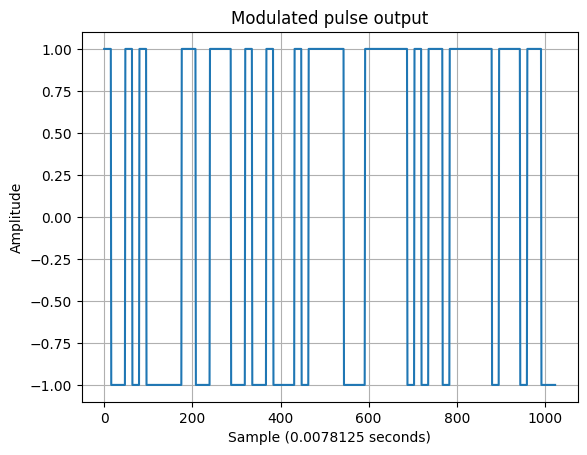

Energy per bit: 0.125 J
Theoretical energy per bit: -9.031 dB


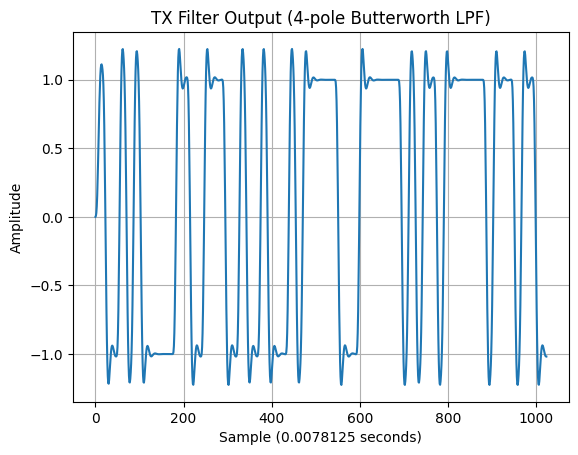

Energy per bit after applying TX filter: 0.113225 J


In [24]:
# Q1
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter

# Simulation Parameters
SAMPLE_RATE = 128  # Hz
SAMPLE_TIME = 1 / SAMPLE_RATE  # ~7.8ms
NUM_BITS = 1024
SAMPLES_PER_BIT = 16
BIT_RATE = SAMPLE_RATE / SAMPLES_PER_BIT  # Bits/second
BIT_PERIOD = 1 / 8  # seconds

# Generate random bits and NRZ modulation
def random_bits(num_bits=NUM_BITS):
    return np.random.randint(0, 2, NUM_BITS)
bits = random_bits()

def nrz_modulation(bits):
    return 2 * bits - 1  # NRZ modulation: 1 -> +1, 0 -> -1

modulator_output = nrz_modulation(bits)

def rect_pulse_shaper(bits, samples_per_bit=SAMPLES_PER_BIT):
    rect_pulse = np.ones(samples_per_bit)
    return np.kron(bits, rect_pulse) # python equivalent to matlab rectpluse
    
modulator_output = rect_pulse_shaper(modulator_output)
# Note: only plotting first 64 bits for visibility
plt.plot(modulator_output[0:1024], label="Modulated pulse output")
plt.title("Modulated pulse output")
plt.xlabel(f"Sample ({1/SAMPLE_RATE} seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Energy per bit calculation
# Measure the energy per bit out of the modulator, by squaring and summing the
# complex absolute value of the modulator output. The sum is then divided by
# the number of samples taken and multiplied by the bit period.
sq_mod = np.abs(modulator_output)**2
total_energy = np.sum(sq_mod)
energy_per_bit = (total_energy / len(modulator_output)) * BIT_PERIOD
print(f"Energy per bit: {energy_per_bit} J")

# Theoretical energy per bit
theoretical_energy_per_bit = 10 * np.log10(1 / 8)
print(f"Theoretical energy per bit: {theoretical_energy_per_bit:.3f} dB")

# Transmit filter (4-pole Butterworth low-pass, fc = 8 Hz)
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Apply the transmit filter
cutoff_frequency = 8  # Hz
filtered_signal = lowpass_filter(modulator_output, cutoff_frequency, SAMPLE_RATE)

plt.plot(filtered_signal[0:1024], label="TX Filter Output")
plt.title("TX Filter Output (4-pole Butterworth LPF)")
plt.xlabel(f"Sample ({1/SAMPLE_RATE} seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Q2
# Measure the energy per bit out of the transmit filter using the method described
# above. Is the energy per bit out of the transmit filter higher or lower than the
# energy per bit out of the modulator. Why?
sq_mod = np.abs(filtered_signal)**2
total_energy = np.sum(sq_mod)
energy_per_bit = (total_energy / len(filtered_signal)) * BIT_PERIOD
print(f"Energy per bit after applying TX filter: {energy_per_bit:.6f} J")

The energy per bit out of the transmit filter is lower than the energy per bit out of the modulator because some energy is lost due to filtering.

### I.A.2 System Calibration - No Noise, Spectral Display

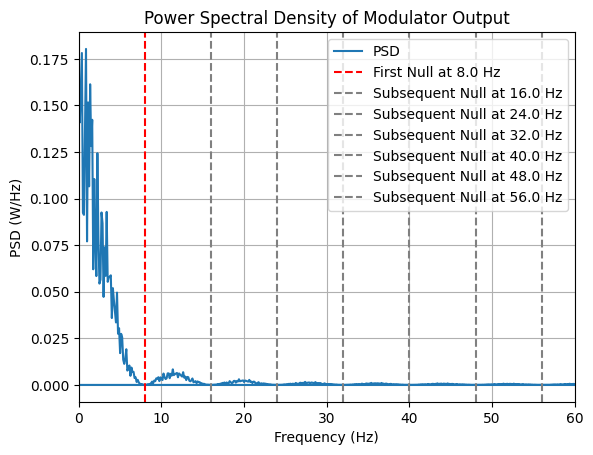

In [25]:
FFT_LENGTH = 1024
NUM_FFTS = 10
RESOLUTION_BANDWIDTH = SAMPLE_RATE / FFT_LENGTH # 0.125Hz

def get_psd_average(signal, bandwidth=RESOLUTION_BANDWIDTH):
    psd_avg = np.zeros(FFT_LENGTH // 2 + 1)
    for _ in range(NUM_FFTS):
        seg = signal[_ * FFT_LENGTH : (_ + 1) * FFT_LENGTH]
        fft_result = np.fft.fft(seg, FFT_LENGTH)
        fft_mag = np.abs(fft_result) / FFT_LENGTH
        psd = fft_mag**2
        psd_avg += psd[:FFT_LENGTH // 2 + 1]

    psd_avg /= NUM_FFTS
    psd_avg /= bandwidth
    return psd_avg

psd_avg = get_psd_average(modulator_output)

freqs = np.fft.fftfreq(FFT_LENGTH, 1 / SAMPLE_RATE)[:FFT_LENGTH // 2 + 1]
plt.plot(freqs, psd_avg, label="PSD")
plt.title("Power Spectral Density of Modulator Output")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (W/Hz)")
plt.xlim(0, 60)
plt.grid()

first_null = 1 / BIT_PERIOD
plt.axvline(x=first_null, color='red', linestyle='--', label=f'First Null at {first_null} Hz')
while first_null < 56:
    first_null += (1 / BIT_PERIOD)
    plt.axvline(x=first_null, color='gray', linestyle='--', label=f"Subsequent Null at {first_null} Hz")
plt.legend()
plt.show()


#### First Null location
The first null in the rectangular pulse-shaped NRZ occurs at:
$$f_{null} = \frac{1}{T_{bit period}}$$

Since the bit period T_{bit period} = 1/8, f_{null} = 8Hz.
Subsequent f_{null}s will occur every 8Hz.

### PSD at 0Hz
Since the signal has no DC component, and NRZ has equal probability of being +1 or -1, the PSD value at 0Hz should be 0W.

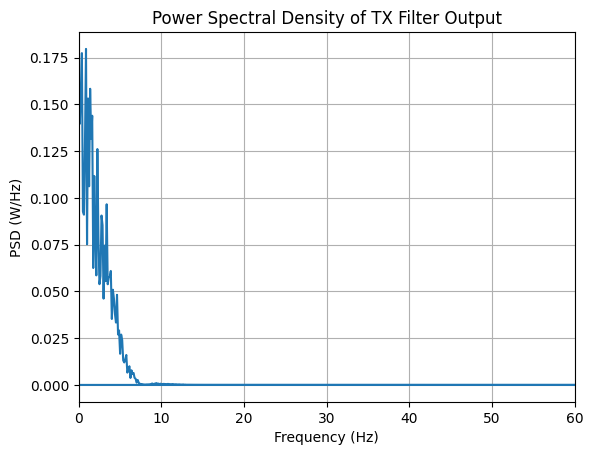

In [26]:
# Q4
# 1. Send the output of the modulator through the transmit filter, and plot the PSD as above.
# What does the transmit filter do to the PSD of the signal?
psd_avg = get_psd_average(filtered_signal)
plt.plot(freqs, psd_avg, label="PSD")
plt.title("Power Spectral Density of TX Filter Output")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (W/Hz)")
plt.xlim(0, 60)
plt.grid()

The transmit filter keeps the PSD of the low frequency components (frequencies less than the cutoff at 8Hz) the same, but drastically reduces the PSD of frequencies > 8Hz.

### I.B. System Calibration - No Signal, Noise Spectrum
I.B. System Calibration – No signal, Noise spectrum
Set up:
1. Data generator – None
2. Pulse shaper – None
3. Modulator – None
4. Xmit Filter – None
5. Noise generator - AWGN
6. Rcv Filter – 4 pole Butterworth low pass, fc = 8 Hz
7. FFT – 1024 point
Q5:
1. Generate a random noise signal having I and Q channels (i.e., independent I and Q noise generators), each having a variance of 1. Calculate the simulated noise variance by summing and averaging the square of the complex absolute value of the noise generator output (I&Q), and report the result.

In [27]:
# Arbitrarily high number of samples
NUM_SAMPLES = 100_000

I_chan = np.random.normal(0, 1, NUM_SAMPLES) # variance = 1
Q_chan = np.random.normal(0, 1, NUM_SAMPLES) # variance = 1

noise_signal = I_chan + 1j * Q_chan

sq_mag = np.abs(noise_signal)**2
simulated_noise_variance = np.mean(sq_mag)
print(f"Simulated Noise Variance: {simulated_noise_variance:.6f}")

Simulated Noise Variance: 2.002284


Q6:
1. Send the noise through the receive filter, and find the noise variance out of the
receive filter. How does this noise variance compare to the input noise variance,
and why?

In [28]:
rx_filtered_noise_signal = lowpass_filter(noise_signal, cutoff_frequency, SAMPLE_RATE)

rx_filtered_sq_mag = np.abs(rx_filtered_noise_signal)**2
rx_filtered_noise_variance = np.mean(rx_filtered_sq_mag)
print(f"Filtered Noise Variance: {rx_filtered_noise_variance:.6f}")

Filtered Noise Variance: 0.253709


The filtered noise variance is much less than the input noise variance because the cutoff frequency is relatively low. All frequency components < 8Hz will be significanly attenuated.

Additionally, the reduction in power should be proportional to the filter's bandwidth and roll-off.

Q7:
1. Calculate the PSD of the noise using the FFT as detailed above, and plot the
PSD before and after the receive filter. Relate the total noise power (prior to the
rcv filter) to the system bandwidth using
$$\sigma^2 = N_0B$$
where, No= noise spectral density, and B = system BW = 128 Hz

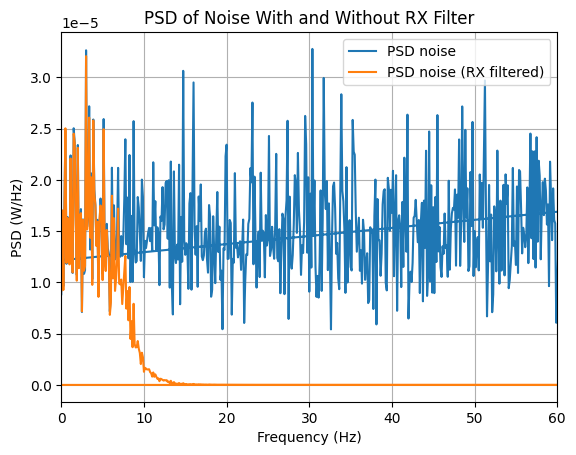

Total Noise Power Without Filtering: 1.004995 W
Total Noise Power With Filtering: 0.133270 W


In [29]:
SYSTEM_BANDWIDTH = 128 # 128Hz
psd_noise_signal = get_psd_average(noise_signal, bandwidth=SYSTEM_BANDWIDTH)
psd_rx_filtered_noise_signal = get_psd_average(rx_filtered_noise_signal, bandwidth=SYSTEM_BANDWIDTH)
plt.plot(freqs, psd_noise_signal, label="PSD noise")
plt.plot(freqs, psd_rx_filtered_noise_signal, label="PSD noise (RX filtered)")
plt.title("PSD of Noise With and Without RX Filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (W/Hz)")
plt.grid()
plt.xlim(0, 60)
plt.legend()
plt.show()

total_noise_power = np.sum(psd_noise_signal) * SYSTEM_BANDWIDTH
total_noise_power_rx_filtered = np.sum(psd_rx_filtered_noise_signal) * SYSTEM_BANDWIDTH
print(f"Total Noise Power Without Filtering: {total_noise_power:.6f} W")
print(f"Total Noise Power With Filtering: {total_noise_power_rx_filtered:.6f} W")

### II.A. System Simulation – Bipolar NRZ – Rect Pulse Shape

Set up:
1. Data generator – Random bits
2. Pulse shaper – Rectangular
3. Modulator – NRZ data (I only)
4. XmitFilter - 4 pole Butterworth low pass, fc=8Hz
5. RcvFilter – 4 pole Butterworth low pass, fc=8Hz
6. FFT – 1024 point

Q8:
1. Plot the PSD out of the modulator. The theoretical PSD is given by:
$$P_x(f) = T_b(\frac{sin(\pi fT_b)}{\pi fT_b})^2$$

Q9:
1. Plot the eye diagram over 2 bit periods at the output of the transmit filter.

Q10:
1. Plot the signal envelope over 2 bit periods at the output of the transmit filter.

Q11:
1. Plot the scatter plot (constellation diagram) at the output of the transmit filter.

/var/folders/n7/zlzgr4j57tl6x2p6cmb5f1n40000gs/T/ipykernel_67028/975117794.py:7: RuntimeWarning: invalid value encountered in divide
  psd_theoretical = BIT_PERIOD * (np.sin(np.pi * freqs * BIT_PERIOD) / (np.pi * freqs * BIT_PERIOD)) ** 2


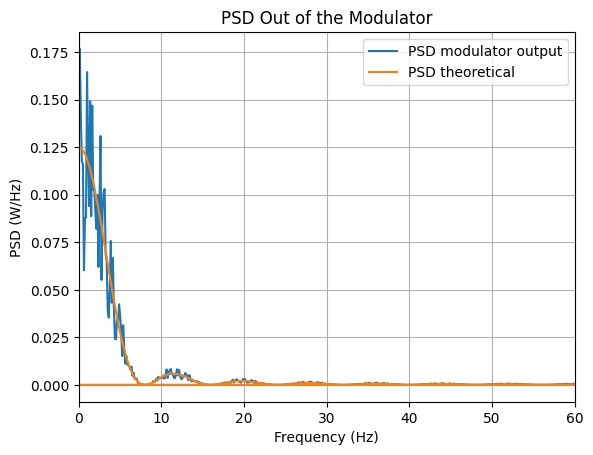

In [30]:
bits = random_bits()
# Note: bit period is the same as in system calibration phase, so nothing was changed there.
modulator_output = nrz_modulation(bits)
modulator_output = rect_pulse_shaper(modulator_output)
psd_mod_out = get_psd_average(modulator_output)

psd_theoretical = BIT_PERIOD * (np.sin(np.pi * freqs * BIT_PERIOD) / (np.pi * freqs * BIT_PERIOD)) ** 2
# division by 0 problem
psd_theoretical[freqs == 0] = BIT_PERIOD

plt.plot(freqs, psd_mod_out, label="PSD modulator output")
plt.plot(freqs, psd_theoretical, label="PSD theoretical")
plt.title("PSD Out of the Modulator")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (W/Hz)")
plt.grid()
plt.xlim(0, 60)
plt.legend()
plt.show()

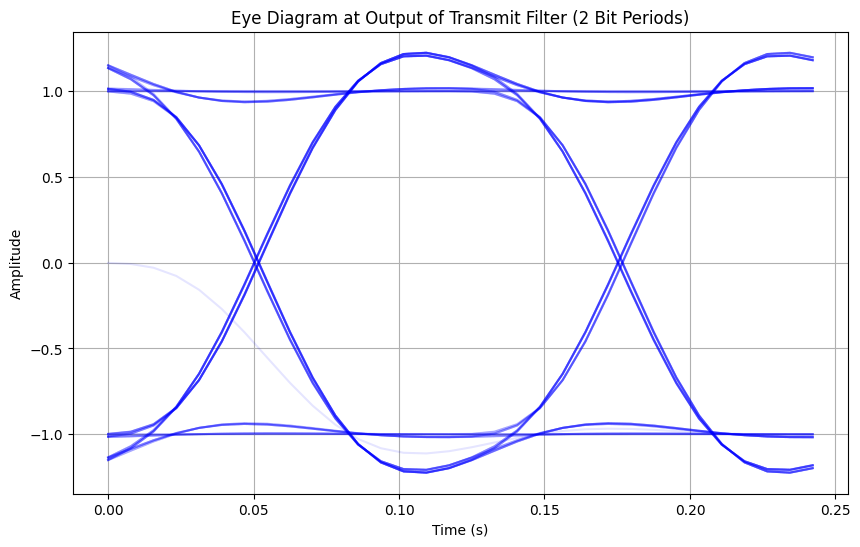

In [31]:
# Apply the transmit filter
cutoff_frequency = 8  # Hz
transmit_filter_out = lowpass_filter(modulator_output, cutoff_frequency, SAMPLE_RATE)

def plot_eye_diagram(signal, samples_per_bit=SAMPLES_PER_BIT, num_eyes=50, title='Eye Diagram at Output of Transmit Filter (2 Bit Periods)'):
    samples_per_eye = 2 * samples_per_bit  # 2 bit periods
    num_intervals = len(signal) // samples_per_eye
    eye_diagram = np.zeros((num_intervals, samples_per_eye))

    for i in range(num_intervals):
        start = i * samples_per_eye
        end = start + samples_per_eye
        eye_diagram[i, :] = signal[start:end]

    plt.figure(figsize=(10, 6))
    for i in range(num_eyes):
        plt.plot(np.arange(0, 2 * BIT_PERIOD, BIT_PERIOD / samples_per_bit), eye_diagram[i, :], color='b', alpha=0.1)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

plot_eye_diagram(transmit_filter_out, SAMPLES_PER_BIT, num_eyes=100)

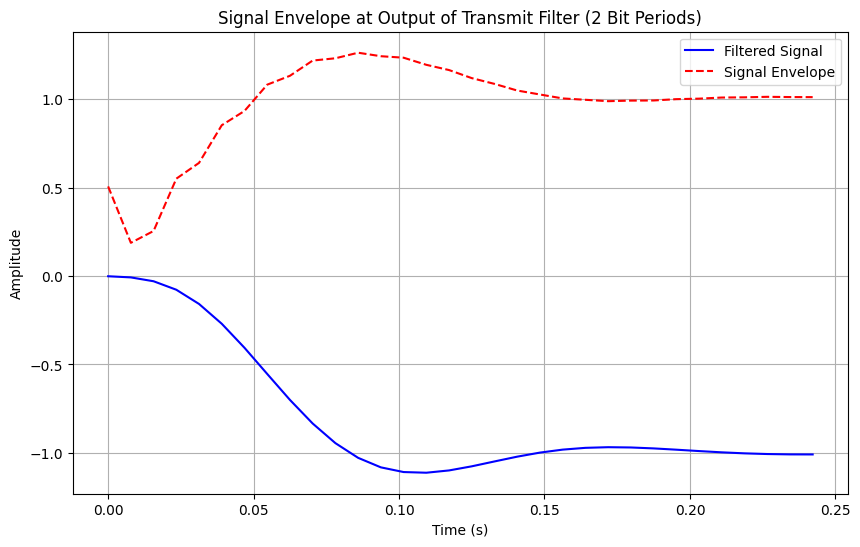

In [32]:
from scipy.signal import hilbert

# Plot the signal envelope over 2 bit periods
def plot_signal_envelope(signal, envelope, samples_per_bit=SAMPLES_PER_BIT, title='Signal Envelope at Output of Transmit Filter (2 Bit Periods)'):
    time = np.arange(0, 2 * BIT_PERIOD, BIT_PERIOD / samples_per_bit)
    plt.figure(figsize=(10, 6))
    plt.plot(time, signal[:len(time)], label='Filtered Signal', color='b')
    plt.plot(time, envelope[:len(time)], label='Signal Envelope', color='r', linestyle='--')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

analytic_signal = hilbert(transmit_filter_out)
signal_envelope = np.abs(analytic_signal)

plot_signal_envelope(transmit_filter_out, signal_envelope)

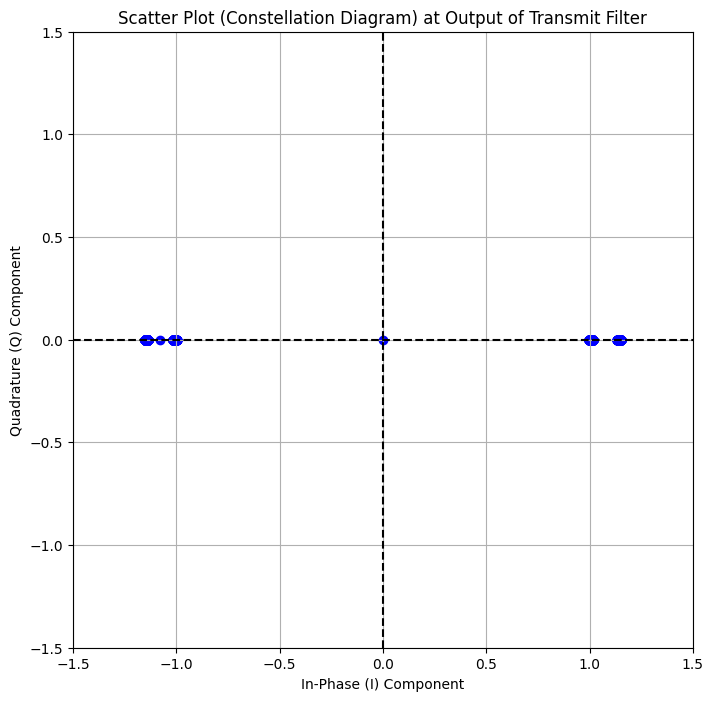

In [33]:
sampled_signal = transmit_filter_out[::SAMPLES_PER_BIT]

def plot_constellation_diagram(sampled_signal, title='Scatter Plot (Constellation Diagram) at Output of Transmit Filter'):
    plt.figure(figsize=(8, 8))
    plt.scatter(sampled_signal, np.zeros_like(sampled_signal), color='b', marker='o')
    plt.title(title)
    plt.xlabel('In-Phase (I) Component')
    plt.ylabel('Quadrature (Q) Component')
    plt.grid()
    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(0, color='black', linestyle='--')
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.show()

plot_constellation_diagram(sampled_signal)

###II.B. System Simulation – Bipolar NRZ – Half SinusoidI.B. System Calibration – No signal, Noise spectrum
Set up:
1. Datagenerator–Randombits
2. Pulseshaper–HalfSinusoid:p(t)=A*sin(pi*t/Tb)
3. Modulator–NRZdata(Ionly)
4. XmitFilter–4poleButterworthlowpass,fc=8Hz
5. RcvFilter–4poleButterworthlowpass,fc=8Hz
6. FFT–1024point
   
Q12:
1. Find the average energy per bit for this signal. Calculate A such that this energy per bit is the same as for the rectangular pulse shape.
Q13:
1. Find the theoretical power spectral density (PSD) of this signal, and plot it.
Q14:
1. Plot the eye diagram over 2 bit periods at the output of the transmit filter.
Q15:
1. Plot the signal envelope over 2 bit periods at the output of the transmit filter.
Q16:
1. Plot the scatter plot (constellation diagram) at the output of the transmit filter.

In [34]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter

bits_I = random_bits()

def calculate_energy_per_bit(signal, bit_period, num_bit = NUM_BITS, samples_per_bit = SAMPLES_PER_BIT):
    numb_samples = num_bit * samples_per_bit
    sq_mod = np.abs(signal) ** 2  # Power at each sample
    total_energy = np.sum(sq_mod)
    energy_per_bit = (np.sum(sq_mod) / numb_samples)*bit_period

    # Convert to dB
    energy_per_bit_db = 10 * np.log10(energy_per_bit)
    return energy_per_bit, energy_per_bit_db


def half_sinusoid_pulse_shaper(bits , samples_per_bit = SAMPLES_PER_BIT, bit_period = BIT_PERIOD, amplitude = 1):
    # Time vector scaled to T_b (0 to T_b)
    t = np.linspace(0, bit_period, samples_per_bit, endpoint=False)

    # Generate half-sinusoidal pulse shape using p(t) = A * sin(pi * t / T_b)
    sin_pulse = amplitude * np.sin(np.pi * t / bit_period)

    # Apply pulse shape to bits using Kronecker product
    shaped_signal = np.kron(bits, sin_pulse)

    return shaped_signal

# Binary NRZ modulation
modulated_I_nrz = nrz_modulation(bits_I)

# Apply Sinusoidal Pulse Shaping
modulator_pulse_shape_I = half_sinusoid_pulse_shaper(modulated_I_nrz)

psd_mod_out = get_psd_average(modulator_output)

psd_avg = get_psd_average(filtered_signal)
plt.plot(freqs, psd_avg, label="PSD")
plt.title("Power Spectral Density of TX Filter Output")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (W/Hz)")
plt.xlim(0, 60)
plt.grid()


TypeError: nrz_modulation() missing 1 required positional argument: 'bits_Q'

In [ ]:
###III.C. System Simulation – 16 QAM – Rectangular Pulse Shape1. Datagenerator–RandombitsI,RandombitsQ
1. Datagenerator–RandombitsI,RandombitsQ
2. Pulseshaper–Rectangular
3. Modulator–NRZdata(IandQ)([-3A,-A,A,3A]) 
4. XmitFilter–4poleButterworthlowpass,fc=8Hz 
5. RcvFilter–4poleButterworthlowpass,fc=8Hz 
6. FFT–1024point
   
Q25:
1. What value of A will give the same energy per symbol as in the previous cases?
Q26:
1. Plot the eye diagram over 2 symbol periods at the output of the transmit filter, for both the I and Q channels.
Q27:
1. Plot the signal envelope over 2 symbol periods at the output of the transmit filter.
Q28:
1. Plot the scatter plot (constellation diagram) at the output of the transmit filter

In [34]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter

bits_I = random_bits()
bits_Q = random_bits()

def map_bits_to_4pam(bits, amplitude=1):
    # Ensure even number of bits
    if len(bits) % 2 != 0:
        bits = np.append(bits, 0)  # Pad with zero if needed

    # Reshape bits into pairs
    bit_pairs = bits.reshape(-1, 2)

    # 4-PAM mapping: 00 -> -3A, 01 -> -A, 10 -> A, 11 -> 3A
    symbol_map = {
        (0, 0): -3 * amplitude,
        (0, 1): -1 * amplitude,
        (1, 0): 1 * amplitude,
        (1, 1): 3 * amplitude
    }

    # Map bit pairs to symbols
    symbols = np.array([symbol_map[tuple(pair)] for pair in bit_pairs])

    return symbols

def half_sinusoid_pulse_shaper(bits , samples_per_bit = SAMPLES_PER_BIT, bit_period = BIT_PERIOD, amplitude = 1):
    # Time vector scaled to T_b (0 to T_b)
    t = np.linspace(0, bit_period, samples_per_bit, endpoint=False)

    # Generate half-sinusoidal pulse shape using p(t) = A * sin(pi * t / T_b)
    sin_pulse = amplitude * np.sin(np.pi * t / bit_period)

    # Apply pulse shape to bits using Kronecker product
    shaped_signal = np.kron(bits, sin_pulse)

    return shaped_signal

# 4-PAM NRZ modulation
modulated_I_4pam = nrz_4pam_modulation(modulated_I_nrz, amplitude=1)
modulated_Q_4pam = nrz_4pam_modulation(modulated_Q_nrz, amplitude=1)

# Apply Rectangular Pulse Shaping
modulator_pulse_shape_I = rect_pulse_shaper(modulated_I_4pam)
modulator_pulse_shape_Q = rect_pulse_shaper(modulated_Q_4pam)


psd_mod_out = get_psd_average(modulator_output)

psd_avg = get_psd_average(filtered_signal)
plt.plot(freqs, psd_avg, label="PSD")
plt.title("Power Spectral Density of TX Filter Output")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (W/Hz)")
plt.xlim(0, 60)
plt.grid()


TypeError: nrz_modulation() missing 1 required positional argument: 'bits_Q'